In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
%watermark

Last updated: 2024-07-18T16:19:23.221986-04:00

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.22.2

Compiler    : MSC v.1937 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 167 Stepping 1, GenuineIntel
CPU cores   : 16
Architecture: 64bit



In [2]:
# Libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm

import os

from func_utils import *

# Display and graph options

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# Customize the font and title size
custom_params = {
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "font.family": "Arial"
}
sns.set_context("notebook", rc=custom_params)

# Set a color palette
sns.set_palette("Set2") 

# Set global option to display numbers in plain format
pd.set_option('display.float_format', '{:.2f}'.format)

# Filter warnings and seeds
import warnings
import random

warnings.filterwarnings('ignore')
random.seed(1234)

In [55]:
# Data 

data_tmp = pd.read_csv('DATA/base_main.csv')

In [56]:
data_tmp.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,...,Transaction_Date2,Month,Coupon_Code,Discount_pct,Discount_pct_ajus,Invoice,Gender,Location,Tenure_Months,month
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,...,2019-01-01,Jan,ELEC10,10.00,10.00,194.37,M,Chicago,12,1
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,...,2019-01-01,Jan,ELEC10,10.00,10.00,194.37,M,Chicago,12,1
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used,...,2019-01-01,Jan,OFF10,10.00,10.00,9.01,M,Chicago,12,1
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used,...,2019-01-01,Jan,SALE10,10.00,0.00,109.93,M,Chicago,12,1
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used,...,2019-01-01,Jan,AIO10,10.00,10.00,28.13,M,Chicago,12,1


# 3. Performing Customer Segmentation
### 3.1. Heuristic (Value based, RFM) – Divide the customers into Premium, Gold, Silver, Standard customers and define strategy on the same.

RFM analysis is a data driven customer behavior segmentation technique. RFM stands for recency, frequency, and monetary value.
The  idea is to segment customers based on when their last purchase was, how often they’ve purchased in the past, and how much they’ve spent overall. 

In [57]:
# Recency
data_tmp['Transaction_Date'] = pd.to_datetime(data_tmp['Transaction_Date'])

# Calculating a reference date (last purchase)
data_ref = data_tmp['Transaction_Date'].max()

# Grouping and calculating the recency
recency_tmp = data_tmp.groupby('CustomerID')['Transaction_Date'].agg('max').reset_index(name = 'last_purchase')
recency_tmp['recency_days'] = (data_ref - recency_tmp['last_purchase']).dt.days

recency_tmp

,CustomerID,last_purchase,recency_days
0,12346,2019-09-15,107
1,12347,2019-11-02,59
2,12348,2019-10-19,73
3,12350,2019-12-14,17
4,12356,2019-09-15,107
...,...,...,...
1463,18259,2019-04-05,270
1464,18260,2019-10-05,87
1465,18269,2019-06-20,194
1466,18277,2019-10-23,69


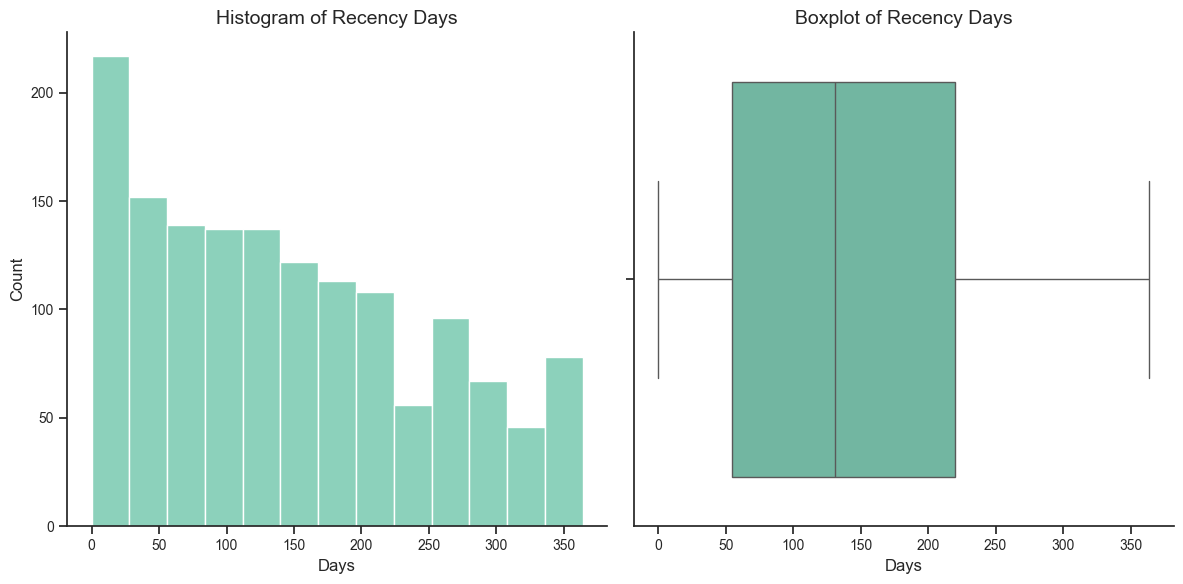

In [58]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram
sns.histplot(recency_tmp['recency_days'], ax=axes[0])
axes[0].set_title('Histogram of Recency Days')
axes[0].set_xlabel('Days')  # Rótulo do eixo X
axes[0].set_ylabel('Count')  # Rótulo do eixo Y

# Boxplot
sns.boxplot(x=recency_tmp['recency_days'], ax=axes[1])
axes[1].set_title('Boxplot of Recency Days')
axes[1].set_xlabel('Days')  # Rótulo do eixo X

# Adjust layout
plt.tight_layout()
plt.show()

In [59]:
# Frequency

frequency = data_tmp['Transaction_ID'].value_counts().reset_index(name = 'frequency')
frequency['frequency'].describe()

count   25061.00
mean        2.11
std         2.18
min         1.00
25%         1.00
50%         1.00
75%         2.00
max        35.00
Name: frequency, dtype: float64

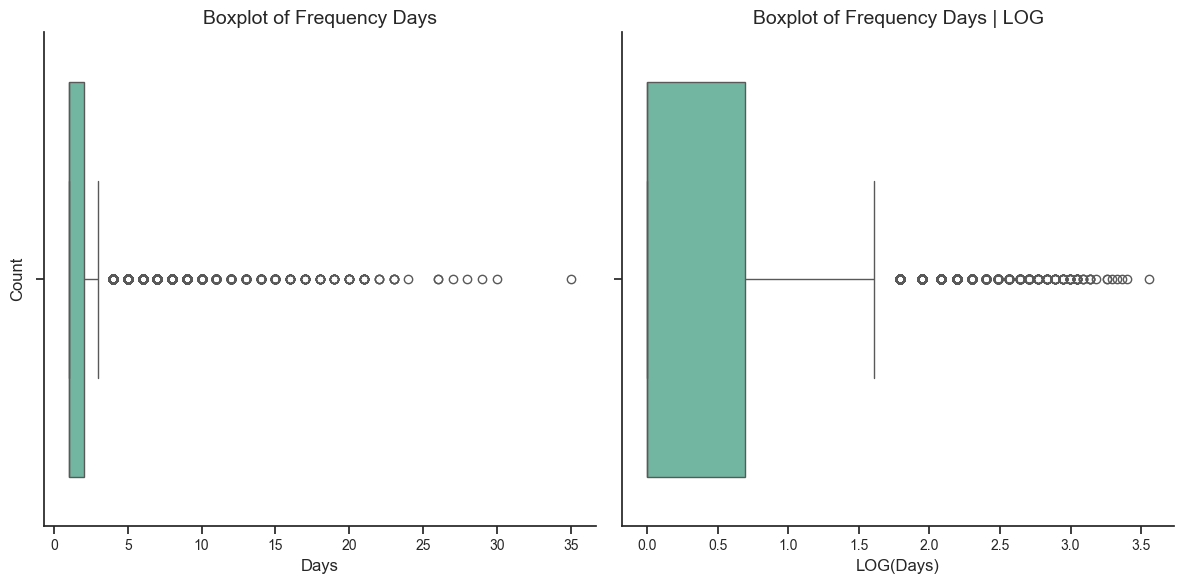

In [60]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

frequency_log = np.log(frequency['frequency'])

# Histogram
sns.boxplot(x = frequency['frequency'], ax=axes[0])
axes[0].set_title('Boxplot of Frequency Days')
axes[0].set_xlabel('Days')  
axes[0].set_ylabel('Count')  

# Boxplot
sns.boxplot(x=frequency_log, ax=axes[1])
axes[1].set_title('Boxplot of Frequency Days | LOG')
axes[1].set_xlabel('LOG(Days)')  


plt.tight_layout()
plt.show()

In [61]:
# Monetary

monetary = data_tmp.groupby(['Transaction_ID'])['Invoice'].agg('sum').reset_index()
monetary

,Transaction_ID,Invoice
0,16679,194.37
1,16680,194.37
2,16681,9.01
3,16682,902.04
4,16684,382.71
...,...,...
25056,48493,139.93
25057,48494,88.97
25058,48495,245.17
25059,48496,449.36


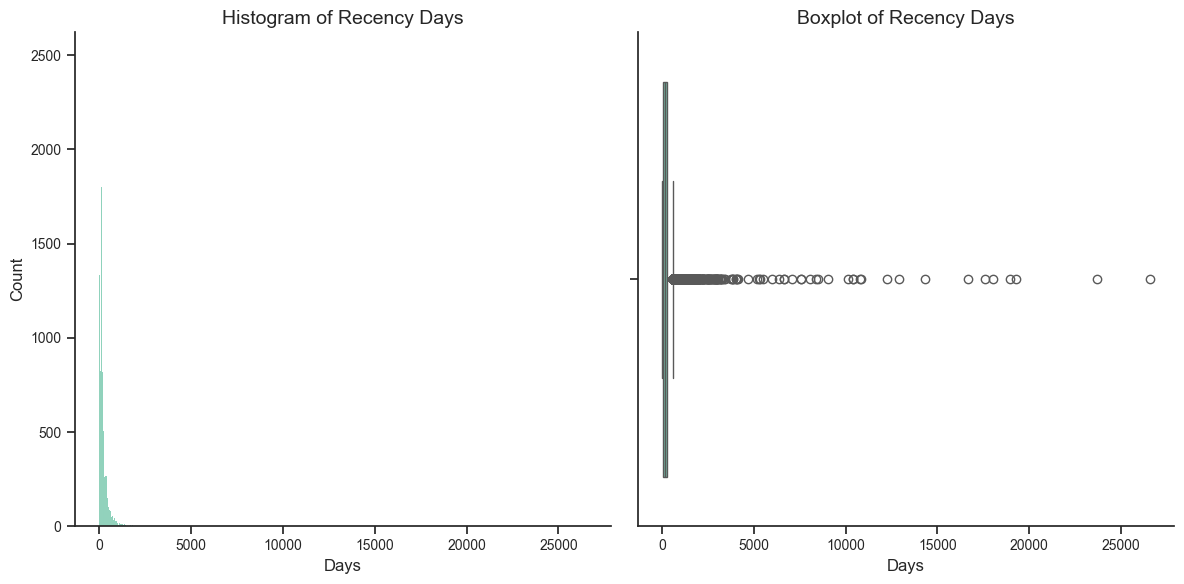

In [62]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram
sns.histplot(monetary['Invoice'], ax=axes[0])
axes[0].set_title('Histogram of Recency Days')
axes[0].set_xlabel('Days')  # Rótulo do eixo X
axes[0].set_ylabel('Count')  # Rótulo do eixo Y

# Boxplot
sns.boxplot(x=monetary['Invoice'], ax=axes[1])
axes[1].set_title('Boxplot of Recency Days')
axes[1].set_xlabel('Days')  # Rótulo do eixo X

# Adjust layout
plt.tight_layout()
plt.show()